# TicTacToe

## Imports y variables

In [1]:
from games.tictactoe.tictactoe import TicTacToe
from agents.agent_random import RandomAgent
from agents.minimax import MiniMax
from agents.mcts_t import MonteCarloTreeSearch
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import time


In [2]:
start = time.time()
for i in range(1000):
    game = TicTacToe(render_mode='')
print(time.time() - start, 'seconds to initialize game')
game.reset()
start = time.time()
for i in range(1000):
    game.clone()
print(time.time() - start, 'seconds to clone game')

0.10909891128540039 seconds to initialize game
0.11012387275695801 seconds to clone game


## Ejemplo basico

In [5]:
agents_rd = dict(map(lambda agent: (agent, RandomAgent(game=game, agent=agent)), game.agents))
agents_rd

{'X': <agents.agent_random.RandomAgent at 0x17c94270690>,
 'O': <agents.agent_random.RandomAgent at 0x17c93b86950>}

In [6]:
game.reset()
while not game.terminated():
    game.render()
    print(game.eval(game.agent_selection))
    action = agents_rd[game.agent_selection].action()
    game.step(action)
game.render()
print(game.eval(game.agent_selection))
print(game.rewards)

Player: X
Board:
 .  .  . 
 .  .  . 
 .  .  . 

0.0
Player: O
Board:
 .  X  . 
 .  .  . 
 .  .  . 

-0.25
Player: X
Board:
 O  X  . 
 .  .  . 
 .  .  . 

-0.125
Player: O
Board:
 O  X  . 
 .  .  . 
 .  X  . 

0.0
Player: X
Board:
 O  X  O 
 .  .  . 
 .  X  . 

-0.25
Player: O
Board:
 O  X  O 
 .  X  . 
 .  X  . 

-1
{'X': 1, 'O': -1}


## Testing MTCT

In [8]:
# MCTS parameters
SIMULATIONS = 100
ROLLOUTS = 5
MCTS_DEPTH = 4

# Minimax Parameters
MINIMAX_DEPTH = 4

In [9]:
# Define agent combinations to test
agent_configs = [
    ("Random vs Random", 
     lambda: RandomAgent(game=game, agent=game.agents[0]), 
     lambda: RandomAgent(game=game, agent=game.agents[1])),
    
    ("MCTS vs Random", 
     lambda: MonteCarloTreeSearch(game=game, agent=game.agents[0], 
                                  simulations=SIMULATIONS, rollouts=ROLLOUTS, depth=MCTS_DEPTH), 
     lambda: RandomAgent(game=game, agent=game.agents[1])),
    
    ("Random vs MCTS", 
     lambda: RandomAgent(game=game, agent=game.agents[0]), 
     lambda: MonteCarloTreeSearch(game=game, agent=game.agents[1],
                                   simulations=SIMULATIONS, rollouts=ROLLOUTS, depth=MCTS_DEPTH)),
    
    ("MCTS vs MiniMax", 
     lambda: MonteCarloTreeSearch(game=game, agent=game.agents[0],
                                   simulations=SIMULATIONS, rollouts=ROLLOUTS, depth=MCTS_DEPTH), 
     lambda: MiniMax(game=game, agent=game.agents[1], depth=MINIMAX_DEPTH)),
    
    ("MiniMax vs MCTS", 
     lambda: MiniMax(game=game, agent=game.agents[0], depth=MINIMAX_DEPTH), 
     lambda: MonteCarloTreeSearch(game=game, agent=game.agents[1],
                                   simulations=SIMULATIONS, rollouts=ROLLOUTS, depth=MCTS_DEPTH)),
    
    ("MCTS vs MCTS", 
     lambda: MonteCarloTreeSearch(game=game, agent=game.agents[0],
                                   simulations=SIMULATIONS, rollouts=ROLLOUTS, depth=MCTS_DEPTH), 
     lambda: MonteCarloTreeSearch(game=game, agent=game.agents[1],
                                   simulations=SIMULATIONS, rollouts=ROLLOUTS, depth=MCTS_DEPTH)),
]

In [10]:
# Run experiments with timing
N_GAMES = 50
results = {}
timing_results = {}

for config_name, agent1_factory, agent2_factory in agent_configs:
    print(f"\n--- Testing {config_name} ---")
    values = defaultdict(list)
    times = defaultdict(list)
    
    for i in range(N_GAMES):
        if (i + 1) % 10 == 0:
            print(f"Game {i+1}/{N_GAMES}")
        
        # Create fresh agents for each game
        players = {
            game.agents[0]: agent1_factory(),
            game.agents[1]: agent2_factory()
        }
        
        game.reset()
        game_times = {agent: [] for agent in game.agents}
        
        while not game.terminated():
            agent = game.agent_selection
            
            # Time the action
            start_time = time.time()
            action = players[agent].action()
            end_time = time.time()
            
            game_times[agent].append(end_time - start_time)
            game.step(action)
        
        # Store rewards and times
        for agent in game.agents:
            values[agent].append(game.reward(agent))
            times[agent].append(np.mean(game_times[agent]) if game_times[agent] else 0)
    
    # Store results
    results[config_name] = values
    timing_results[config_name] = times
    
    # Print summary with timing
    for agent in game.agents:
        avg_reward = np.mean(values[agent])
        avg_time = np.mean(times[agent]) * 1000  # Convert to milliseconds
        wins = sum(1 for r in values[agent] if r > 0)
        draws = sum(1 for r in values[agent] if r == 0)
        losses = sum(1 for r in values[agent] if r < 0)
        
        print(f"Agent {agent}: Avg={avg_reward:.3f}, Wins={wins}, Draws={draws}, Losses={losses}, Avg Time={avg_time:.2f}ms")



--- Testing Random vs Random ---
Game 10/50
Game 20/50
Game 30/50
Game 40/50
Game 50/50
Agent X: Avg=0.260, Wins=30, Draws=3, Losses=17, Avg Time=0.02ms
Agent O: Avg=-0.260, Wins=17, Draws=3, Losses=30, Avg Time=0.01ms

--- Testing MCTS vs Random ---
Game 10/50
Game 20/50
Game 30/50
Game 40/50
Game 50/50
Agent X: Avg=0.980, Wins=49, Draws=1, Losses=0, Avg Time=96.02ms
Agent O: Avg=-0.980, Wins=0, Draws=1, Losses=49, Avg Time=0.03ms

--- Testing Random vs MCTS ---
Game 10/50
Game 20/50
Game 30/50
Game 40/50
Game 50/50
Agent X: Avg=-0.720, Wins=4, Draws=6, Losses=40, Avg Time=0.01ms
Agent O: Avg=0.720, Wins=40, Draws=6, Losses=4, Avg Time=83.74ms

--- Testing MCTS vs MiniMax ---
Game 10/50
Game 20/50
Game 30/50
Game 40/50
Game 50/50
Agent X: Avg=0.200, Wins=19, Draws=22, Losses=9, Avg Time=90.00ms
Agent O: Avg=-0.200, Wins=9, Draws=22, Losses=19, Avg Time=122.75ms

--- Testing MiniMax vs MCTS ---
Game 10/50
Game 20/50
Game 30/50
Game 40/50
Game 50/50
Agent X: Avg=0.700, Wins=35, Draws=1

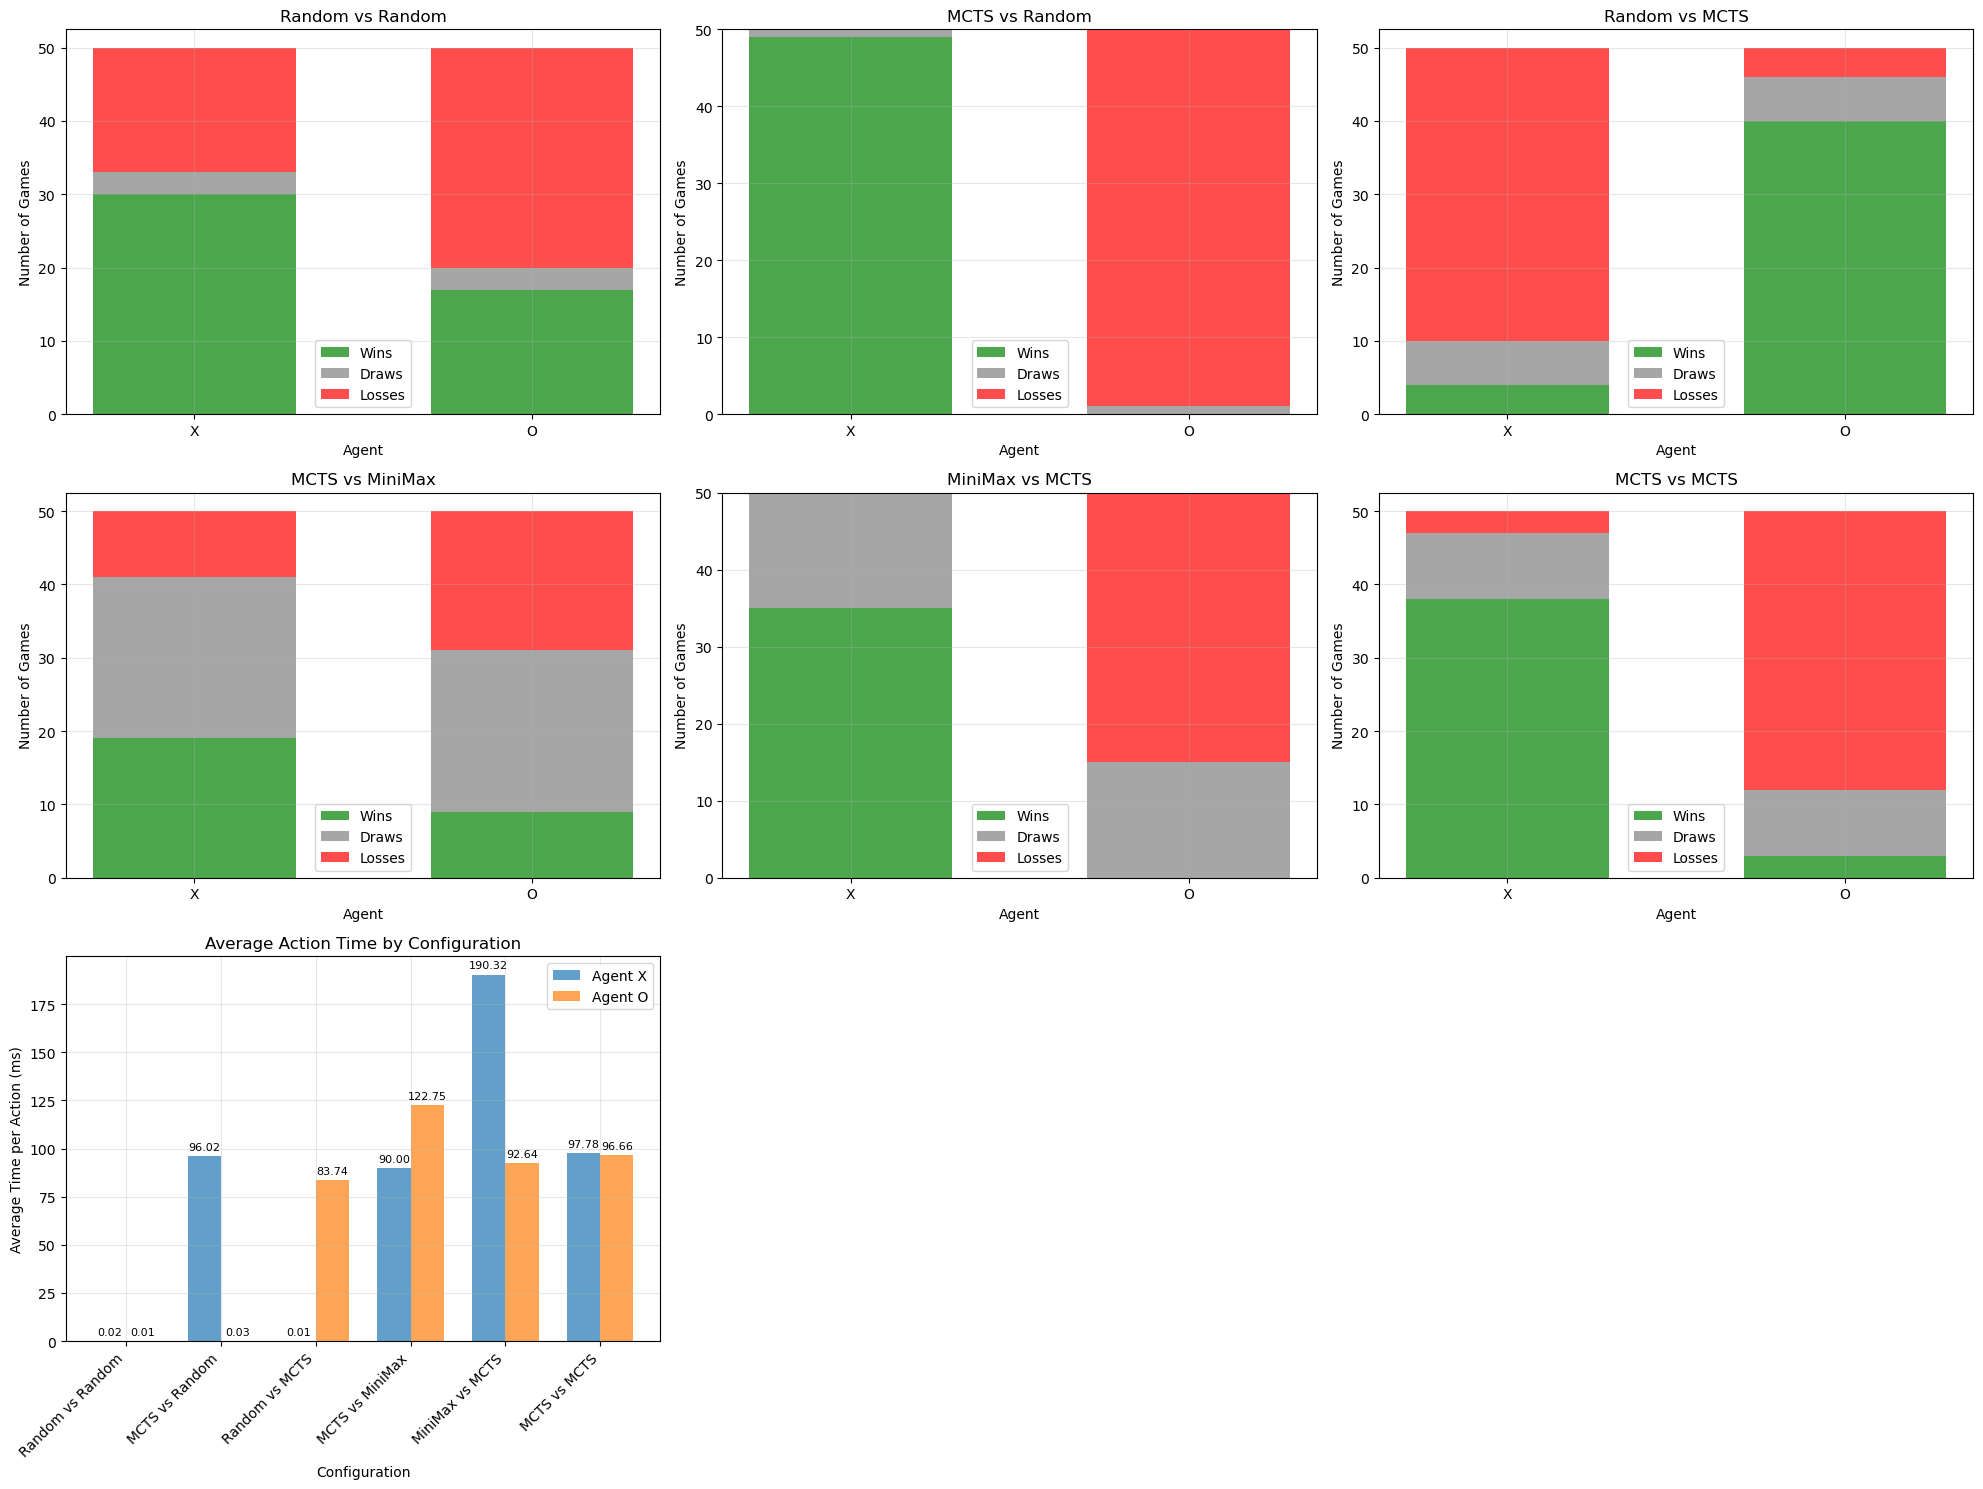

In [11]:
# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Performance plots (first 2 rows)
for i, (config_name, values) in enumerate(results.items()):
    if i < 6:
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Create win/draw/loss counts
        agent_names = list(values.keys())
        
        win_counts = []
        draw_counts = []
        loss_counts = []
        
        for agent in agent_names:
            wins = sum(1 for r in values[agent] if r > 0)
            draws = sum(1 for r in values[agent] if r == 0)
            losses = sum(1 for r in values[agent] if r < 0)
            
            win_counts.append(wins)
            draw_counts.append(draws)
            loss_counts.append(losses)
        
        # Stacked bar chart
        x = np.arange(len(agent_names))
        width = 0.6
        
        ax.bar(x, win_counts, width, label='Wins', color='green', alpha=0.7)
        ax.bar(x, draw_counts, width, bottom=win_counts, label='Draws', color='gray', alpha=0.7)
        ax.bar(x, loss_counts, width, bottom=np.array(win_counts) + np.array(draw_counts), 
               label='Losses', color='red', alpha=0.7)
        
        ax.set_title(config_name)
        ax.set_xlabel('Agent')
        ax.set_ylabel('Number of Games')
        ax.set_xticks(x)
        ax.set_xticklabels(agent_names)
        ax.legend()
        ax.grid(True, alpha=0.3)

# Timing comparison (third row)
timing_comparison = []
timing_labels = []
timing_configs = []

for config_name, times in timing_results.items():
    for agent, agent_times in times.items():
        avg_time = np.mean(agent_times) * 1000  # Convert to milliseconds
        timing_comparison.append(avg_time)
        timing_labels.append(f"{agent}")
        timing_configs.append(config_name)

# Group timing data by configuration
timing_data = {}
for config_name, times in timing_results.items():
    timing_data[config_name] = [np.mean(times[agent]) * 1000 for agent in game.agents]

# Plot timing comparison
ax_timing = axes[2, 0]
configs = list(timing_data.keys())
x = np.arange(len(configs))
width = 0.35

agent1_times = [timing_data[config][0] for config in configs]
agent2_times = [timing_data[config][1] for config in configs]

bars1 = ax_timing.bar(x - width/2, agent1_times, width, label=f'Agent {game.agents[0]}', alpha=0.7)
bars2 = ax_timing.bar(x + width/2, agent2_times, width, label=f'Agent {game.agents[1]}', alpha=0.7)

ax_timing.set_xlabel('Configuration')
ax_timing.set_ylabel('Average Time per Action (ms)')
ax_timing.set_title('Average Action Time by Configuration')
ax_timing.set_xticks(x)
ax_timing.set_xticklabels(configs, rotation=45, ha='right')
ax_timing.legend()
ax_timing.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax_timing.annotate(f'{height:.2f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax_timing.annotate(f'{height:.2f}',
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=8)

# Hide empty subplots
axes[2, 1].set_visible(False)
axes[2, 2].set_visible(False)

plt.tight_layout()
plt.show()

In [12]:
# Enhanced summary table with timing
print("\n" + "="*100)
print("ENHANCED SUMMARY TABLE WITH TIMING")
print("="*100)
print(f"{'Configuration':<20} {'Agent':<12} {'Wins':<6} {'Draws':<6} {'Losses':<8} {'Win Rate':<10} {'Avg Time (ms)':<15}")
print("-" * 100)

for config_name, values in results.items():
    for agent in values.keys():
        wins = sum(1 for r in values[agent] if r > 0)
        draws = sum(1 for r in values[agent] if r == 0)
        losses = sum(1 for r in values[agent] if r < 0)
        win_rate = wins / N_GAMES
        avg_time = np.mean(timing_results[config_name][agent]) * 1000
        
        print(f"{config_name:<20} {agent:<12} {wins:<6} {draws:<6} {losses:<8} {win_rate:<10.3f} {avg_time:<15.2f}")
    print()


ENHANCED SUMMARY TABLE WITH TIMING
Configuration        Agent        Wins   Draws  Losses   Win Rate   Avg Time (ms)  
----------------------------------------------------------------------------------------------------
Random vs Random     X            30     3      17       0.600      0.02           
Random vs Random     O            17     3      30       0.340      0.01           

MCTS vs Random       X            49     1      0        0.980      96.02          
MCTS vs Random       O            0      1      49       0.000      0.03           

Random vs MCTS       X            4      6      40       0.080      0.01           
Random vs MCTS       O            40     6      4        0.800      83.74          

MCTS vs MiniMax      X            19     22     9        0.380      90.00          
MCTS vs MiniMax      O            9      22     19       0.180      122.75         

MiniMax vs MCTS      X            35     15     0        0.700      190.32         
MiniMax vs MCTS    

## Profiling

In [3]:
# Install pyinstrument if not already installed
# !pip install pyinstrument

from pyinstrument import Profiler

# Create and start profiler
profiler = Profiler()
profiler.start()

print("Profiling MCTS vs MCTS...")

# Run a few games between MCTS agents
N_GAMES = 5
SIMULATIONS = 100
ROLLOUTS = 3

for i in range(N_GAMES):
    print(f"Game {i+1}/{N_GAMES}")
    
    # Create MCTS agents
    mcts1 = MonteCarloTreeSearch(game=game, agent=game.agents[0])
    mcts2 = MiniMax(game=game, agent=game.agents[1], depth=4)
    
    players = {game.agents[0]: mcts1, game.agents[1]: mcts2}
    
    # Play the game
    game.reset()
    while not game.terminated():
        agent = game.agent_selection
        action = players[agent].action()
        game.step(action)

# Stop profiler
profiler.stop()

# Save HTML report
with open('optimized.html', 'w') as f:
    f.write(profiler.output_html())

print("Profiling complete! Report saved to 'mcts_profile.html'")
print("Open the HTML file in your browser to view the detailed profiling results.")

Profiling MCTS vs MCTS...
Game 1/5
Game 2/5
Game 3/5
Game 4/5
Game 5/5
Profiling complete! Report saved to 'mcts_profile.html'
Open the HTML file in your browser to view the detailed profiling results.
